<font size = "5"> **EELS_Tools:  [Spectroscopy](../4_EELS_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of Core-Loss EELS Spectra
<br>

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/EELS/Analysis_Core_Loss.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/EELS/Analysis_Core_Loss.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package


Notebook by Gerd Duscher, 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes




## Content

Quantitative determination of chemical composition from a core-loss EELS spectrum

Relavant notebooks in course [MSE 672: Introduction to TEM]()  give an in depth explanation of the method.

Please cite:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of this quantification method.

## Prerequesites
This notebook will only run with  ``pyTEMlib version 0.2023.5.0`` or higher.

### Install missing packages
This can take a while for the first time. This code will have to run at least once on your computer and for each colab session.

In [1]:
import sys

from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2023.12.1':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/sidpy -q --upgrade
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/SciFiReaders.git@main -q
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade
    
if 'google.colab' in sys.modules:
    !{sys.executable} -m pip install numpy==1.24.4
# ------------------------------
print('done')

!{sys.executable} -m pip install git+https://github.com/pycroscopy/sidpy --upgrade

done


C:\Users\gduscher\AppData\Local\Temp\ipykernel_31396\3377828473.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import get_distribution, DistributionNotFound


  Cloning https://github.com/pycroscopy/sidpy to c:\users\gduscher\appdata\local\temp\pip-req-build-_zwry03r
  Resolved https://github.com/pycroscopy/sidpy to commit e26388783fb08932a845988907341a9f44960077
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/sidpy 'C:\Users\gduscher\AppData\Local\Temp\pip-req-build-_zwry03r'
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scifireaders 0.10.0 requires numba==0.57.1, but you have numba 0.58.1 which is incompatible.


Restart the Runtime in Runtime Menu above or pres "Ctrl-M"

### Load the relevant packages

In [3]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../../sidpy')

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

import sidpy
import pyTEMlib
import pyTEMlib.file_tools as ft     # File input/ output library
import pyTEMlib.image_tools as it
import pyTEMlib.eels_tools  as eels        # EELS methods 

import pyTEMlib.interactive_eels as ieels  # Dialogs for EELS input and quantification

if 'google.colab' in sys.modules:
    drive.mount("/content/drive")

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ', pyTEMlib.__version__)

print(sidpy.__version__)
__notebook__ = 'analyse_core_loss'
__notebook_version__ = '2023_12_09'

ModuleNotFoundError: No module named 'ipython_genutils'

## Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.

Please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details on storage and plotting.

First a dialog to select a file will apear.

Then the spectrum plot and ``Spectrum Info`` dialog will appear, in which we set the experimental parameters.

Please use the ``Set Energy Scale`` button to change the energy scale. When pressed a new dialog and a cursor will appear in which one is able to set the energy scale based on known features in the spectrum.


In [2]:
# -----Input -------#
load_example = False

if load_example:
    datasets = ft.open_file('../../example_data/EELS_STO3.hf5')
else:  
    fileWidget = ft.FileWidget()


Please use new SciFiReaders Package for full functionality


In [3]:
infoWidget= ieels.InfoWidget(fileWidget.datasets, fileWidget.selected_key)

AppLayout(children=(GridspecLayout(children=(Dropdown(description='Main Dataset:', index=1, layout=Layout(grid…

In [5]:
infoWidget.dataset.metadata


{'experiment': {'single_exposure_time': 0.499001996007984,
  'number_of_frames': 1,
  'collection_angle': 50.0,
  'convergence_angle': 0.5,
  'exposure_time': 0.499,
  'acceleration_voltage': 200000.0,
  'flux_ppm': 1657886.9231132374,
  'count_conversion': 1,
  'beam_current': 0,
  'low_loss_reference': 'Channel_002'},
 'filename': 'C:\\Users\\gduscher\\Downloads\\STEM SI.dm4'}

## Chemical Composition 
The fit of the cross-section and background to the spectrum results in the chemical composition. If the calibration is correct this composition is given as areal density in atoms/nm$^2$




In [ ]:
print('Auto Quantification')
eels.auto_chemical_composition(infoWidget.dataset)

###  Fit of Data
A dashboardw will open.
Press **Elements** to select the elements first.

Pres``Quantification`` button. Adjust parameters as needed and check fit by pressing the ``Quantification`` button again.

Select the ``Fit Area`` button will show you which parts of the spectrum you choose to fit.

Changing the multiplier value will make a simulation of your spectrum.

Probability will change to atoms/nm$^2$ if you selected a reference for the counts in the info dashboard above.
Edges button will display the edges of the te selected elements.

If a low-loss spectrum is selected a 

In [6]:
 compositionWidget = ieels.CompositionWidget(fileWidget.datasets, fileWidget.selected_key)

AppLayout(children=(GridspecLayout(children=(ToggleButton(value=False, button_style='info', description='Fit A…

(38, 23, 2)

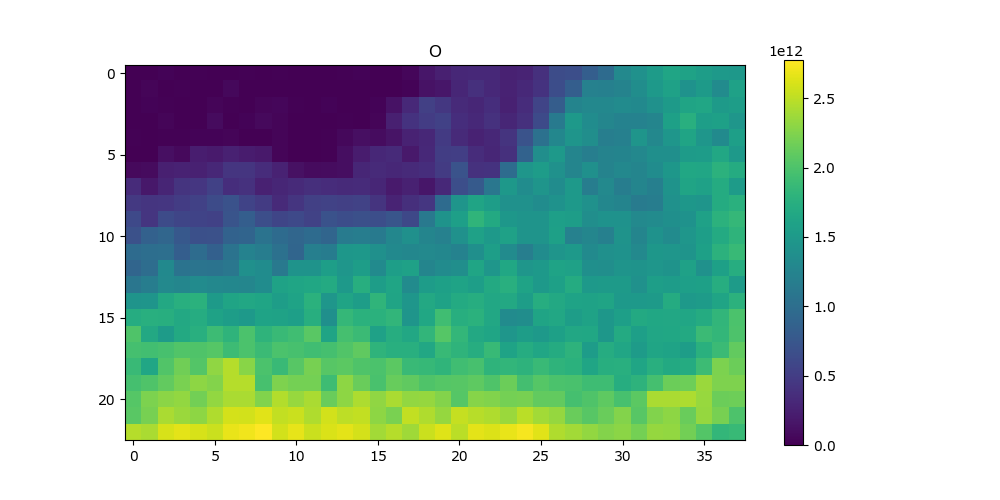

In [10]:
element = 0

results = compositionWidget.dataset.metadata['edges']['spectrum_image_quantification']

plt.figure(figsize=(10,5))
plt.title(compositionWidget.dataset.metadata['edges'][str(element)]['element'])
im = plt.imshow((results[:,:,element]).T)
cbar = plt.colorbar(im)
results.shape

In [6]:
compositionWidget.dataset.metadata['edges']['0']['element']

'O'

(38, 23, 2)

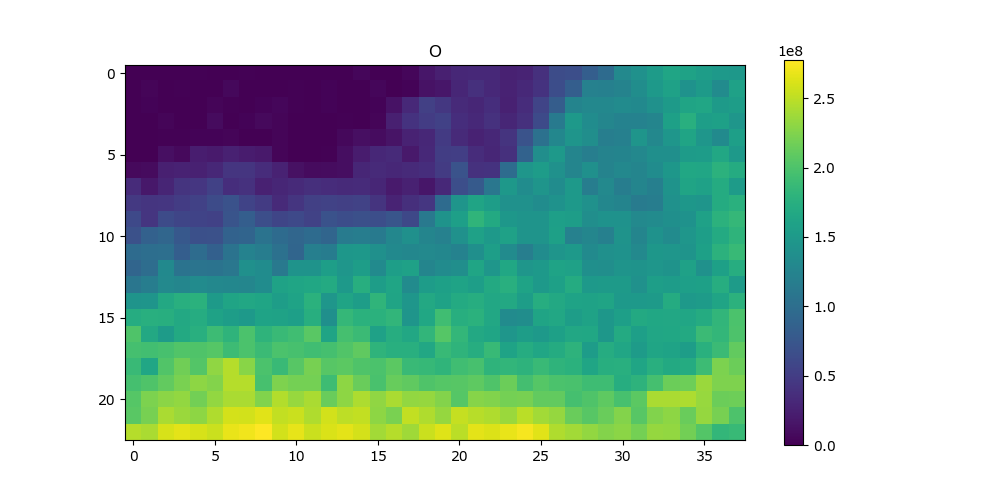

In [7]:
element = 0
plt.figure(figsize=(10,5))
plt.title(compositionWidget.dataset.metadata['edges'][str(element)]['element'])
im = plt.imshow((results[:,:,element]).T)
cbar = plt.colorbar(im)
results.shape

(38, 23, 2)

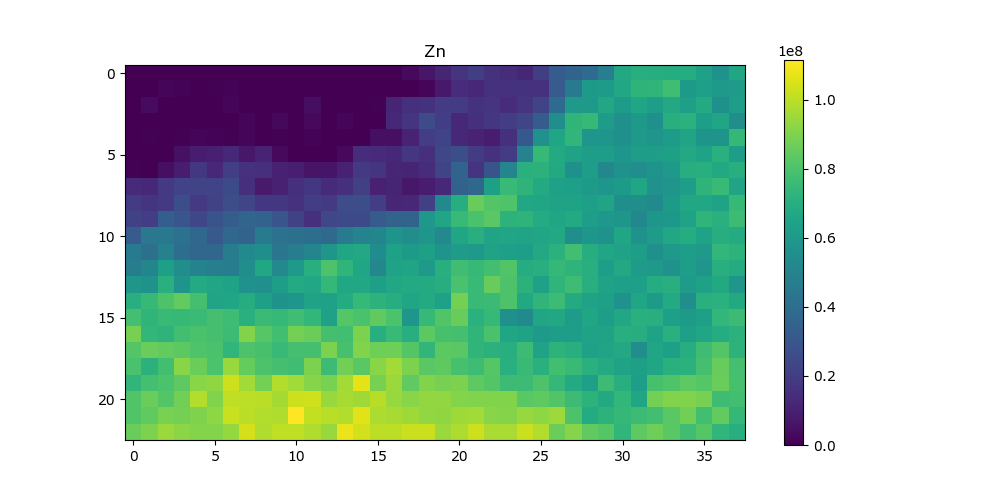

In [ ]:
element = 1
plt.figure(figsize=(10,5))
plt.title(compositionWidget.dataset.metadata['edges'][str(element)]['element'])
im = plt.imshow((results[:,:,element]).T)
cbar = plt.colorbar(im)
results.shape

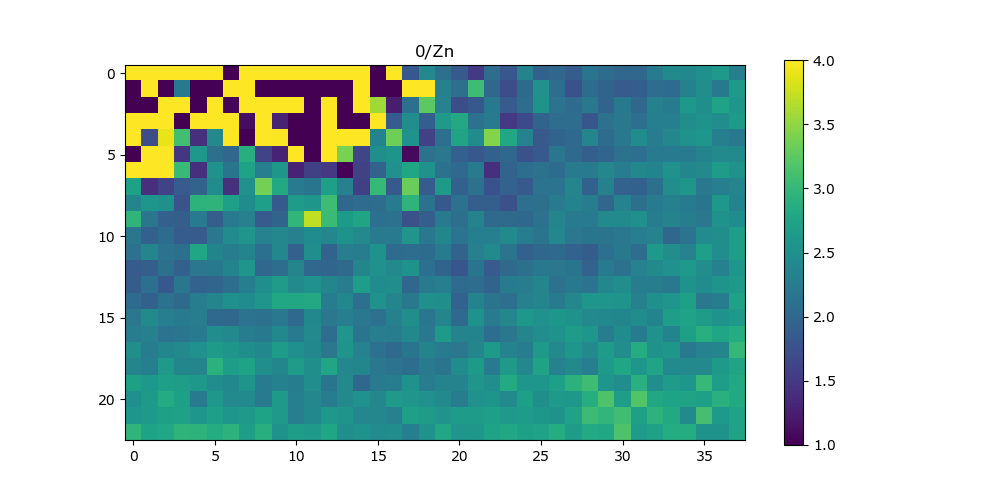

In [11]:
plt.figure(figsize=(10,5))
plt.title('0/Zn')
im = plt.imshow((results[:,:,0]/results[:,:,1]).T, vmax = 4, vmin =1)
cbar = plt.colorbar(im)

In [ ]:
import pyTEMlib.eels_tools
x_sections = pyTEMlib.eels_tools.get_x_sections(13)
x_sections

{'name': 'Al',
 'barns': 448039000000.0,
 'NumEdges': 5,
 'atomic_weight': 26.9815,
 'nominal_density': 2.6941,
 'photoabs_to_sigma': 44.8039,
 'lines': {'K-L3': {'weight': 1.0, 'position': 1486.5000000000002},
  'K-L2': {'weight': 0.505, 'position': 1486.5000000000002}},
 'M1': {'filename': 'None',
  'excl before': 5,
  'excl after': 50,
  'onset': 8.37567,
  'factor': 1.0},
 'L3': {'filename': 'Al.L3',
  'excl before': 5,
  'excl after': 50,
  'onset': 73.1,
  'factor': 1.0,
  'twin': 'L2'},
 'L2': {'filename': 'None',
  'excl before': 5,
  'excl after': 50,
  'onset': 73.1,
  'factor': 0.5},
 'L1': {'filename': 'Al.L1',
  'excl before': 5,
  'excl after': 50,
  'onset': 117.7,
  'factor': 1.0},
 'K1': {'filename': 'Al.K1',
  'excl before': 5,
  'excl after': 50,
  'onset': 1559.6,
  'factor': 1.0,
  'shape': 'hydrogenic'},
 'dat': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.56605764e+15,
        7.39846801e+15, 1.19953481e+15, 9.20272106e+14, 7.81738447e+14,
        7.2

### Output of Results

In [ ]:
edges = compositionWidget.dataset.metadata['edges']
element = []
areal_density = []
for key, edge in edges.items():
    if key.isdigit():
        element.append(edge['element'])
        areal_density.append(edge['areal_density'])

print('Relative chemical composition of ', compositionWidget.dataset.title)
for i in range(len(element)):
    print(f'{element[i]}: {areal_density[i]/np.sum(areal_density)*100:.1f} %')
    
saved_edges_metadata = edges

Relative chemical composition of  2EELS Acquire (high-loss)
B: 51.5 %
Lu: 0.0 %
N: 48.5 %


### Log Data
All the data associated with quantification are stored in the ``metadata`` attribute. The relevant keys of that dictionary are:  ``experiment`` and  ``edges``.

In [ ]:
compositionWidget.dataset.view_metadata()

experiment :
	single_exposure_time : 0.499001996007984
	number_of_frames : 1
	collection_angle : 50.0
	convergence_angle : 30.0
	exposure_time : 0.499
	acceleration_voltage : 200000.0
	flux_ppm : 1657886.9231132374
	count_conversion : 1
	beam_current : 0
	offset : 180.0
	dispersion : 0.5
	SI_bin_x : 1
	SI_bin_y : 1
filename : C:\Users\gduscher\Downloads\STEM SI.dm4
edges :
	model :
	use_low_loss : False
	fit_area :
		fit_start : 207.0
		fit_end : 1203.0
	0 :
		z : 6
		symmetry : K1
		element : C
		onset : 283.8
		end_exclude : 333.8
		start_exclude : 278.8
		all_edges :
			K1 :
				onset : 283.8
		chemical_shift : 0.0
		areal_density : 0.0
		original_onset : 283.8
		data : [1.68668767e-09 1.67124853e-09 1.65580939e-09 ... 2.90940440e-11
 2.90369897e-11 2.89799354e-11]
		X_section_type : XRPA
		X_section_source : pyTEMlib
	1 :
		z : 7
		symmetry : K1
		element : N
		onset : 401.6
		end_exclude : 451.6
		start_exclude : 396.6
		all_edges :
			K1 :
				onset : 401.6
		chemical_shift : 0.0

## ELNES
The electron energy-loss near edge structure is determined by fititng the spectrum after quantification model subtraction. 

First smooth the spectrum (only 0 iteration available at this time) and then 
find the number of peaks you want (Can be repeated as oftern as one wants).

Please note that the peaks do not necessarily have a physcial meaning as there are peaks with 
positive and negative amplitudes. The goal is to get a smooth representation of the spectrum.
A difference of a good fit and the data should result in a residual of noise only. To achieve such a good fit, the careful setting of the edge onset is important.


In [ ]:
datasets['Channel_000'].metadata['peak_fit'] ={}
peakFitWidget = ieels.PeakFitWidget(datasets)

AppLayout(children=(GridspecLayout(children=(Button(description='Fit Area', layout=Layout(grid_area='widget001…

In [ ]:
peakFitWidget.dataset.metadata['edges']['0']

{'z': 22,
 'symmetry': 'L3',
 'element': 'Ti',
 'onset': 455.5,
 'end_exclude': 505.5,
 'start_exclude': 450.5,
 'all_edges': {'L3': {'onset': 455.5},
  'L2': {'onset': 461.5},
  'L1': {'onset': 563.6999999999999}},
 'chemical_shift': 0.0,
 'areal_density': 7321568622261.2295,
 'original_onset': 455.5,
 'data': array([1.10801890e-09, 1.10556278e-09, 1.10310666e-09, ...,
        4.40886101e-10, 4.40394599e-10, 4.39903096e-10]),
 'X_section_type': 'XRPA',
 'X_section_source': 'pyTEMlib'}

In [ ]:
peakFitWidget.fit_peaks()

In [ ]:
peakFitWidget.find_white_lines()

found_whiteline
found_whiteline
found_whiteline

{'Ti-L2': 1378553.3487112543} {}


### Output

In [ ]:
areas = []
for p, peak in peakFitWidget.peaks['peaks'].items():
    area = np.sqrt(2* np.pi)* peak['amplitude'] * np.abs(peak['width'] / np.sqrt(2 *np.log(2))) 
    areas.append(area)
    if 'associated_edge' not in peak:
        peak['associated_edge']= ''
    print(f"peak  {p}: position: {peak['position']:7.1f}, area: {area:12.3f} associated edge: {peak['associated_edge']}")
#print(f'\n M4/M5 peak 2 to peak 1 ratio: {(areas[1])/areas[0]:.2f}')

peak  0: position:   202.7, area:   295255.152 associated edge: Lu-N5
peak  1: position:   196.6, area:   234068.641 associated edge: Lu-N5
peak  2: position:   396.8, area:   213137.318 associated edge: Lu-N3
peak  3: position:   211.9, area:   176496.712 associated edge: Lu-N4
peak  4: position:   588.9, area:     5303.275 associated edge: 
peak  5: position:   403.5, area:    55048.012 associated edge: N-K1
peak  6: position:   504.9, area:     8558.729 associated edge: 
peak  7: position:   497.2, area:     6761.448 associated edge: 
peak  8: position:   501.5, area:     4158.402 associated edge: 
peak  9: position:   189.8, area:     5164.456 associated edge: B-K1
peak  10: position:   596.4, area:     2558.082 associated edge: 
peak  11: position:   554.5, area:     3810.613 associated edge: Lu-N1
peak  12: position:   459.8, area:     3578.335 associated edge: Lu-N2
peak  13: position:   611.4, area:     3527.711 associated edge: 
peak  14: position:   582.9, area:     2849.939 

### Log Data
All the data associated with quantification are stored in the ``metadata`` attribute. 
The new key in that dictionary is: ``peak_fit``.

In [ ]:
infoWidget.dataset.metadata.keys()

dict_keys(['experiment', 'filename', 'edges', 'peak_fit'])

## Save and Close File
The dataset with the metadata should be saved for further quantification. 
The file needs to be closed to be used with other notebooks.

In [ ]:
h5_group = ft.save_dataset(infoWidget.datasets, '../../example_data/EELS_STO3.hf5')
h5_group.file.close()

Cannot overwrite file. Using:  EELS_STO3-1.hf5


C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_io.py:111: UserWarning: main_data_name should not contain the "-" character. Reformatted name from:ronchigram-0.5mu to ronchigram_0.5mu
  warn('main_data_name should not contain the "-" character. Reformatted'
C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
